(16236,)
(667, 620)


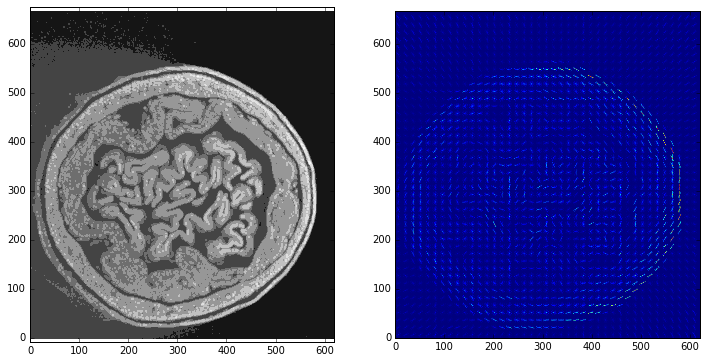

In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.measure import moments
from skimage.feature import hog
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
from scipy.interpolate import interp2d

# open first image to get the image dimensions
im1 = np.array(Image.open('sargentii_17/batch3_tomo_areaij_sample17.0503.tif'),dtype=np.double)

clustered_img1 = KMeans(2).fit_predict(im1.reshape([np.prod(np.shape(im1)),1]))            
clustered_img1[clustered_img1 == clustered_img1[0]] = 2e0
clustered_img1[clustered_img1 != clustered_img1[0]] = 3e0
clustered_img1 = clustered_img1 - 2e0
clustered_img1 = clustered_img1.reshape(np.shape(im1))
clustered_img1 = np.array(clustered_img1,dtype=np.double)

m1 = moments(clustered_img1)
cr1 = m1[0, 1] / m1[0, 0]
cc1 = m1[1, 0] / m1[0, 0]


feature_vector, hog_image = hog(im1,orientations=9,pixels_per_cell=(15,15),cells_per_block=(1,1),visualise=True,normalise=True)

print np.shape(feature_vector)
print np.shape(hog_image)


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.ylim([0,np.shape(im1)[0]])
plt.xlim([0,np.shape(im1)[1]])
plt.contourf(im1,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.ylim([0,np.shape(hog_image)[0]])
plt.xlim([0,np.shape(hog_image)[1]])
plt.imshow(hog_image)
plt.savefig('imgs/hog_image.png',dpi=150)

plt.show()


(800,)
[ 0.45892761  0.          0.04706064  0.          0.49401173  0.          0.
  0.        ]


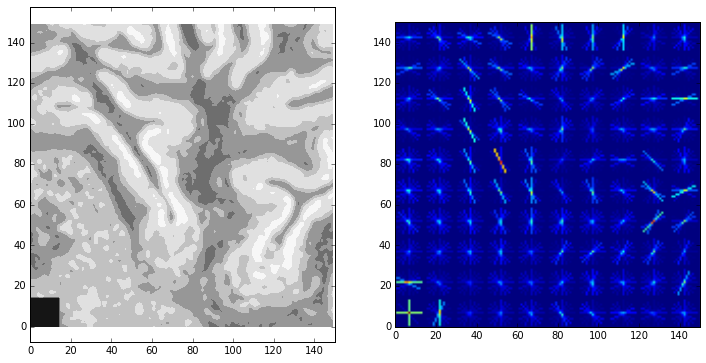

In [79]:
# test: how to reshape the feature vector

im_test = im1[150:300,150:300]
im_test[:15,:15] = 0e0

feature_vector, hog_image = hog(im_test,orientations=8,pixels_per_cell=(15,15),cells_per_block=(1,1),visualise=True,\
                                normalise=True)
print np.shape(feature_vector)
reshaped = feature_vector.reshape(10,10,8)

print reshaped[0,0,:]

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.ylim([0,np.shape(im_test)[0]])
plt.xlim([0,np.shape(im_test)[1]])
plt.contourf(im_test,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.ylim([0,np.shape(hog_image)[0]])
plt.xlim([0,np.shape(hog_image)[1]])
plt.imshow(hog_image)
plt.savefig('imgs/hog_image_test.png',dpi=150)

plt.show()


(8,)
[ 0.29131603  0.          0.          0.          0.29131603  0.
  0.41198308  0.        ]


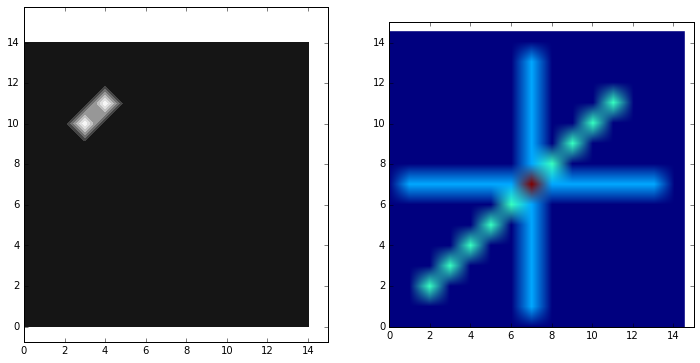

In [90]:
# play around with hog features

im_test = np.zeros([15,15])
im_test[10,3] = 1e0
im_test[11,4] = 1e0

ori = 8

feature_vector, hog_image = hog(im_test,orientations=ori,pixels_per_cell=(15,15),cells_per_block=(1,1),visualise=True,\
                                normalise=True)
print np.shape(feature_vector)
reshaped = feature_vector.reshape(1,1,ori)

print reshaped[0,0,:]

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.ylim([0,np.shape(im_test)[0]])
plt.xlim([0,np.shape(im_test)[1]])
plt.contourf(im_test,cmap='Greys_r')
#plt.scatter(cr1,cc1,color='r')

plt.subplot(1, 2, 2)
plt.ylim([0,np.shape(hog_image)[0]])
plt.xlim([0,np.shape(hog_image)[1]])
plt.imshow(hog_image)
plt.savefig('imgs/hog_image_test.png',dpi=150)

plt.show()


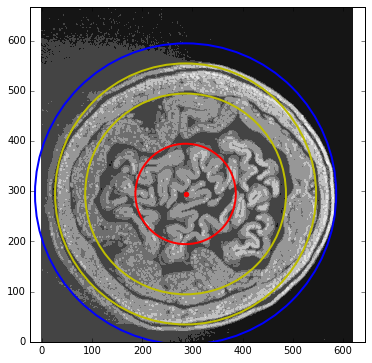

In [113]:
# mark the regions of the three classes

plt.axis('equal')
plt.ylim([0,np.shape(im1)[0]])
plt.xlim([0,np.shape(im1)[1]])
plt.contourf(im1,cmap='Greys_r')
plt.scatter(cr1,cc1,color='r')
circle1 = plt.Circle((cr1,cc1),100,color='r',fill=False,lw=2)
circle2 = plt.Circle((cr1,cc1),200,color='y',fill=False,lw=2)
circle3 = plt.Circle((cr1,cc1),260,color='y',fill=False,lw=2)
circle4 = plt.Circle((cr1,cc1),300,color='b',fill=False,lw=2)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)
plt.savefig('imgs/hog_image_classes.png',dpi=150)
plt.show()

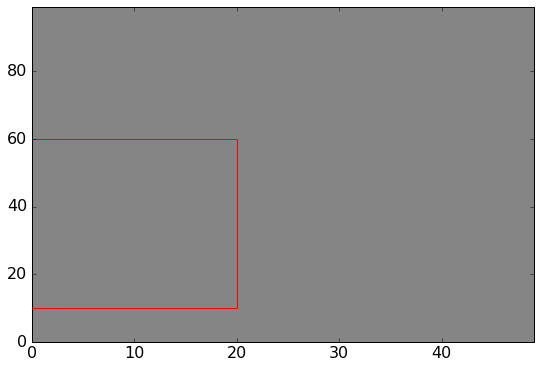

In [18]:
# test image and rectangle routines
dummy_im = np.zeros([50,100])

plt.contourf(dummy_im.T,cmap='Greys_r')
square = plt.Rectangle((0,10),20,50,color='r',fill=False)
plt.gca().add_patch(square)
plt.show()

In [20]:
# obtain the dataset and run the SVM
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
import pickle

cell_sizes = [10,15,20,25,30,35,40,45,50]

# number of simulations 
n_sim = 100

# range of C and gamma values
# the range used to be wider: -8e0,3e0 with num = 12
# experience showed that the best C is within this reduced range usually
C = 10e0**(np.linspace(0e0,3e0,4))
gamma = 10e0**(np.linspace(0e0,4e0,5))

train_score = np.zeros([len(cell_sizes),n_sim,len(C),len(gamma)])
test_score = np.zeros([len(cell_sizes),n_sim,len(C),len(gamma)])
CV_score = np.zeros([len(cell_sizes),n_sim,len(C),len(gamma)])
SVMs = []
Xs = []
Ys = []
for c in range(len(cell_sizes)):
    print 'cell size:',cell_sizes[c]
    # randomly select pixels and check whether they are within any of the regions. 
    # Get 1000 points per class and the hog features.

    background = np.zeros([1000,8])
    leaf = np.zeros([1000,8])
    shell = np.zeros([1000,8])
    i = 0
    j = 0
    k = 0

    plt.axis('equal')
    plt.contourf(im1.T,cmap='Greys_r')
    circle1 = plt.Circle((cr1,cc1),100,color='r',fill=False,lw=2)
    circle2 = plt.Circle((cr1,cc1),200,color='y',fill=False,lw=2)
    circle3 = plt.Circle((cr1,cc1),270,color='y',fill=False,lw=2)
    circle4 = plt.Circle((cr1,cc1),300,color='b',fill=False,lw=2)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(circle4)
    
    while i < 1000 or j < 1000 or k < 1000:

        # get random pixel from the image
        x = np.random.randint(np.shape(im1)[0]-cell_sizes[c])
        y = np.random.randint(np.shape(im1)[1]-cell_sizes[c])

        # the distances of the corners from the center
        dist1 = np.linalg.norm(np.array([cr1,cc1])-np.array([x,y]))
        dist2 = np.linalg.norm(np.array([cr1,cc1])-np.array([x+cell_sizes[c],y]))
        dist3 = np.linalg.norm(np.array([cr1,cc1])-np.array([x,y+cell_sizes[c]]))
        dist4 = np.linalg.norm(np.array([cr1,cc1])-np.array([x+cell_sizes[c],y+cell_sizes[c]]))

        # check whether the corners of the square fall within any of the regions

        if np.all(np.array([dist1,dist2,dist3,dist4]) < 100) and i < 1000:
            # leaf
            # get the hog features of this cell
            leaf[i,:] = hog(im1[x:x+cell_sizes[c],y:y+cell_sizes[c]],orientations=8,\
                            pixels_per_cell=(cell_sizes[c],cell_sizes[c]),cells_per_block=(1,1),\
                            normalise=True)
            square = plt.Rectangle((x,y),cell_sizes[c],cell_sizes[c],color='r',fill=False)
            plt.gca().add_patch(square)
            i = i + 1


        if np.all(np.array([dist1,dist2,dist3,dist4]) > 200) and np.all(np.array([dist1,dist2,dist3,dist4]) < 270) and j < 1000:
            # shell
            shell[j,:] = hog(im1[x:x+cell_sizes[c],y:y+cell_sizes[c]],orientations=8,\
                             pixels_per_cell=(cell_sizes[c],cell_sizes[c]),cells_per_block=(1,1),\
                            normalise=True)
            square = plt.Rectangle((x,y),cell_sizes[c],cell_sizes[c],color='y',fill=False)
            plt.gca().add_patch(square)
            j = j + 1


        if np.all(np.array([dist1,dist2,dist3,dist4]) > 300) and k < 1000:
            # background
            background[k,:] = hog(im1[x:x+cell_sizes[c],y:y+cell_sizes[c]],orientations=8,\
                                  pixels_per_cell=(cell_sizes[c],cell_sizes[c]),cells_per_block=(1,1),\
                                  normalise=True)
            square = plt.Rectangle((x,y),cell_sizes[c],cell_sizes[c],color='b',fill=False)
            plt.gca().add_patch(square)
            k = k + 1

    plt.savefig('imgs/hog_image_cells_'+str(cell_sizes[c])+'.png',dpi=150)
    plt.close()
    

    X = np.concatenate((background,leaf,shell),axis=0)
    Y = np.concatenate((np.zeros(1000),np.zeros(1000)+1,np.zeros(1000)+2))
    
    Xs.append(X)
    Ys.append(Y)
    
    # run the SVM
    
    for i in range(n_sim):
        if i%10 == 0:
            print '   ',i
        # shuffle and split data
        indx = np.arange(np.shape(X)[0])
        np.random.shuffle(indx)
        # split 60-20-20%
        split1 = int(np.shape(X)[0]*0.6)
        split2 = int(np.shape(X)[0]*0.8)
        X_train = X[indx[:split1]]
        Y_train = Y[indx[:split1]]
        X_test = X[indx[split1:split2]]
        Y_test = Y[indx[split1:split2]]
        X_CV = X[indx[split2:]]
        Y_CV = Y[indx[split2:]]


        # train SVM and loop through all C and gamma combinations
        for j in range(len(C)):
            for k in range(len(gamma)):
                #print '      C and gamma:',C[j],gamma[k]
                SVC_bud = SVC(kernel='rbf', C=C[j], gamma=gamma[k]).fit(X_train, Y_train)            
                train_score[c,i,j,k] = SVC_bud.score(X_train,Y_train)
                test_score[c,i,j,k] = SVC_bud.score(X_test,Y_test)
                CV_score[c,i,j,k] = SVC_bud.score(X_CV,Y_CV)


        # find the C and gamma parameters that give max score.
        # if there are multiple parameter configuration giving max score, the first one of these is used below 


    avg_score = np.mean(test_score[c,:,:,:],axis=0)
    avg_CV_score = np.mean(CV_score[c,:,:,:],axis=0)
    std_CV_score = np.std(CV_score[c,:,:,:],axis=0)
    
    best_params = np.where(avg_score == np.max(avg_score))
    print '   best C value(s):',C[best_params[0]]
    print '   best gamma value(s):',gamma[best_params[1]]
    print '   max test score:',np.max(avg_score)

    print 'CV score:',avg_CV_score[best_params],'+/-',std_CV_score[best_params]
    # train the best SVM and save it
    SVC_bud = SVC(kernel='rbf', C=C[best_params[0][0]], gamma=gamma[best_params[1][0]]).fit(X, Y)            
    SVMs.append(SVC_bud)

    
# save the results
f = open('SVM_scores_nsim'+str(n_sim)+'.dat','w')
pickle.dump([test_score,train_score,CV_score,SVMs,Xs,Ys,cell_sizes,C,gamma],f)
f.close()

    


cell size: 10
    0
    10
    20
    30
    40
    50
    60
    70
    80
    90
   best C value(s): [ 100.]
   best gamma value(s): [ 10.]
   max test score: 0.5798
CV score: [ 0.58158333] +/- [ 0.01894785]
cell size: 15
    0
    10
    20
    30
    40
    50
    60
    70
    80
    90
   best C value(s): [ 100.]
   best gamma value(s): [ 10.]
   max test score: 0.674783333333
CV score: [ 0.67496667] +/- [ 0.01571443]
cell size: 20
    0
    10
    20
    30
    40
    50
    60
    70
    80
    90
   best C value(s): [ 1000.]
   best gamma value(s): [ 10.]
   max test score: 0.729
CV score: [ 0.72845] +/- [ 0.01846657]
cell size: 25
    0
    10
    20
    30
    40
    50
    60
    70
    80
    90
   best C value(s): [ 10.]
   best gamma value(s): [ 100.]
   max test score: 0.791533333333
CV score: [ 0.79418333] +/- [ 0.01548027]
cell size: 30
    0
    10
    20
    30
    40
    50
    60
    70
    80
    90
   best C value(s): [ 10.]
   best gamma value(s): [ 1000.]
   m

In [2]:
# render the images
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
from skimage.util.shape import view_as_windows
import pickle


f = open('SVM_scores_nsim100.dat','r')
[test_score,train_score,CV_score,SVMs,Xs,Ys,cell_sizes,C,gamma] = pickle.load(f)
f.close()

for c in range(len(cell_sizes)):
    print c
    windows = view_as_windows(im1,(cell_sizes[c],cell_sizes[c]))
    
    hog_features = np.zeros([np.shape(windows)[0],np.shape(windows)[1],8])

    class_img = np.zeros([np.shape(windows)[0],np.shape(windows)[1]])

    # collect the hog features
    for i in range(np.shape(windows)[0]):
        for j in range(np.shape(windows)[1]):
            hog_features[i,j,:] = hog(windows[i,j],orientations=8,\
                                pixels_per_cell=(cell_sizes[c],cell_sizes[c]),cells_per_block=(1,1),\
                                normalise=True)

    # predict the classes:
    SVC_bud = SVMs[c]
    for i in range(np.shape(windows)[0]):
        class_img[i,:] = SVC_bud.predict(hog_features[i,:,:])

    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.axis('equal')
    plt.xlim([0,np.shape(im1)[0]])
    plt.ylim([0,np.shape(im1)[1]])
    plt.contourf(im1.T,cmap='Greys_r')
    #plt.scatter(cr1,cc1,color='r')

    plt.subplot(1, 2, 2)
    plt.xlim([0,np.shape(hog_image)[0]])
    plt.ylim([0,np.shape(hog_image)[1]])
    plt.imshow(class_img.T)
    plt.savefig('imgs/class_image_cell_size'+str(cell_sizes[c])+'.png',dpi=150)
    plt.close()


0
1
2
3
4
5
6
7
8


[[ 0.34158889  0.34158889  0.34158889  0.41087222  0.53195556  0.64196667
   0.78315     0.99425     1.        ]
 [ 0.34158889  0.34158889  0.40845556  0.4853      0.58238889  0.69943333
   0.91425556  1.          1.        ]
 [ 0.34158889  0.40817222  0.45808889  0.53361667  0.63153333  0.75551111
   0.98866667  1.          1.        ]
 [ 0.40811667  0.45369444  0.49147222  0.57944444  0.66313889  0.81658889
   0.99992778  1.          1.        ]]
[[ 0.00869334  0.00869334  0.00869334  0.01302283  0.00895513  0.00798162
   0.00717121  0.00163748  0.        ]
 [ 0.00869334  0.00869334  0.01355318  0.02148649  0.00849637  0.00688171
   0.00516172  0.          0.        ]
 [ 0.00869334  0.01369741  0.02011561  0.00832981  0.00736069  0.00677718
   0.00226078  0.          0.        ]
 [ 0.01370521  0.01958117  0.01794029  0.00870043  0.00773256  0.00646215
   0.00020268  0.          0.        ]]
[[ 0.32393333  0.32393333  0.32391667  0.4026      0.52628333  0.62273333
   0.67126667  0.639

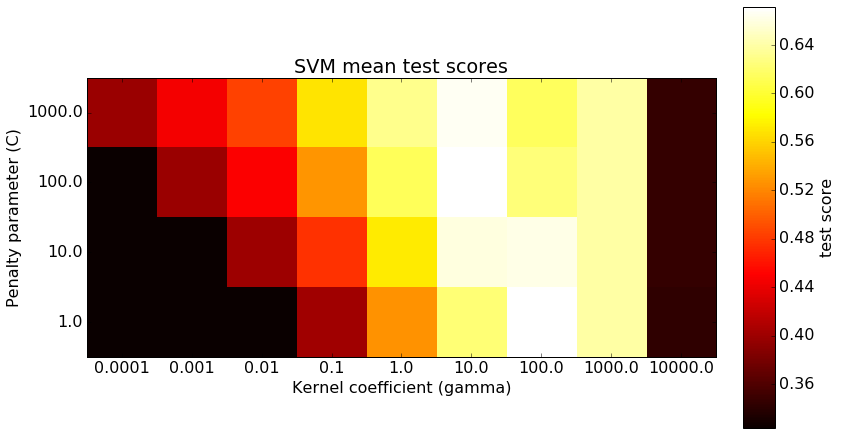

In [165]:
# plot the results
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pickle

f = open('SVM_scores_nsim100.dat','r')
[test_score,train_score,CV_score,C,gamma] = pickle.load(f)
f.close()
    
avg_t_score = np.mean(train_score,axis=0)
std_t_score = np.std(train_score,axis=0)

avg_score = np.mean(test_score,axis=0)
std_score = np.std(test_score,axis=0)

print avg_t_score
print std_t_score

print avg_score
print std_score

print np.mean(CV_score),np.std(CV_score)
plt.ticklabel_format(axis='x', style='sci')
plt.imshow(avg_score,interpolation='nearest',origin='lower',cmap = 'hot',extent=(np.log10(gamma[0])-0.5,np.log10(gamma[-1])+0.5, np.log10(C[0])-0.5,np.log10(C[-1])+0.5))
plt.xticks(np.linspace(-4e0,4e0,9),gamma)
plt.yticks(np.linspace(0e0,3e0,4),C)
plt.xlabel('Kernel coefficient (gamma)')
plt.ylabel('Penalty parameter (C)')
plt.title('SVM mean test scores')
cb1 = plt.colorbar(fraction=0.046, pad=0.04,aspect=13.3)
cb1.set_label('test score')
plt.tight_layout()
plt.savefig('imgs/SVM_test_scores.pdf')
plt.savefig('imgs/SVM_test_scores.jpg',dpi=150)
plt.show()



In [174]:
# confusion matrix

# run the SVM

# read in the data, separate cats and dogs, divide up the data, train the classifier and calculate logloss scores
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
from sklearn.svm import SVC
import pickle
from sklearn.metrics import confusion_matrix


# number of simulations 
n_sim = 100


CV_score = np.zeros(n_sim)
conf_mat = np.zeros([3,3])

for i in range(n_sim):
    print i
    # shuffle and split data
    indx = np.arange(np.shape(X)[0])
    np.random.shuffle(indx)
    # split 60-20-20%
    split1 = int(np.shape(X)[0]*0.8)
    X_train = X[indx[:split1]]
    Y_train = Y[indx[:split1]]
    X_CV = X[indx[split1:]]
    Y_CV = Y[indx[split1:]]
        

    # the CV score
    SVC_bud = SVC(kernel='rbf', C=100e0, gamma=10e0).fit(X_train, Y_train)
    Y_pred = SVC_bud.predict(X_CV)
    CV_score[i] = SVC_bud.score(X_CV,Y_CV)
    conf_mat = conf_mat + confusion_matrix(Y_CV,Y_pred)
    
    print '   CV score:',CV_score[i]
    
    

conf_mat = conf_mat/(3000*0.2*100)
    

0
   CV score: 0.678333333333
1
   CV score: 0.69
2
   CV score: 0.695
3
   CV score: 0.688333333333
4
   CV score: 0.653333333333
5
   CV score: 0.675
6
   CV score: 0.693333333333
7
   CV score: 0.693333333333
8
   CV score: 0.695
9
   CV score: 0.683333333333
10
   CV score: 0.668333333333
11
   CV score: 0.673333333333
12
   CV score: 0.671666666667
13
   CV score: 0.661666666667
14
   CV score: 0.671666666667
15
   CV score: 0.675
16
   CV score: 0.691666666667
17
   CV score: 0.676666666667
18
   CV score: 0.705
19
   CV score: 0.683333333333
20
   CV score: 0.69
21
   CV score: 0.673333333333
22
   CV score: 0.675
23
   CV score: 0.686666666667
24
   CV score: 0.693333333333
25
   CV score: 0.673333333333
26
   CV score: 0.67
27
   CV score: 0.705
28
   CV score: 0.701666666667
29
   CV score: 0.64
30
   CV score: 0.68
31
   CV score: 0.685
32
   CV score: 0.69
33
   CV score: 0.666666666667
34
   CV score: 0.691666666667
35
   CV score: 0.726666666667
36
   CV score: 0.665
37
 

[[ 0.2701      0.014       0.04905   ]
 [ 0.05371667  0.20381667  0.07565   ]
 [ 0.08006667  0.04686667  0.20673333]]


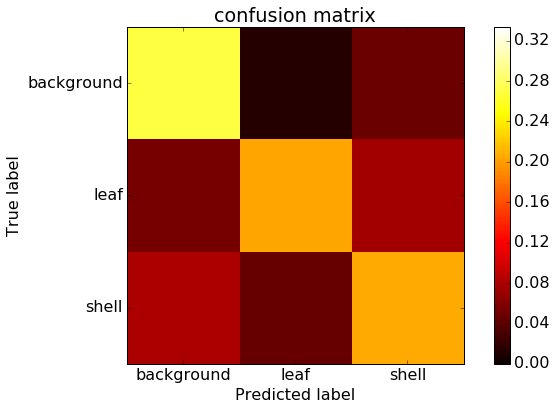

In [179]:

print conf_mat

plt.imshow(conf_mat, interpolation='nearest', cmap='hot',vmin=0,vmax=1e0/3e0)
plt.title('confusion matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['background','leaf','shell'], rotation=0)
plt.yticks(tick_marks, ['background','leaf','shell'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('imgs/SVM_conf_mat.pdf')
plt.savefig('imgs/SVM_conf_mat.jpg',dpi=150)
plt.show()